# CNN Demo
TO DO: add a CoLab badge

Can a convolutional neural network (CNN) be trained to distinguish RNA
from nucleotide composition alone?
More specifically, can a CNN learn to classify  
AT-rich sequence with the label "protein coding"
from GC-rich sequence with the label "non-coding"?

This demo uses an RNA sequence simulator.
The simulator strictly follows a frequency histogram with values for A, C, G, T.
This is a noise-free simulation.

The CNN is almost as simple as can be.
It has one trainiable convolution layer (one dimensional) with 8 filters.
It has one flatten layer simply to reshape the data.
It has a trainable fully connected (dense) output layer with 1 neuron.
More sophisticated models would incorporate embedding, pooling, dropout,
multiple convolution layers, and multiple dense layers.

The training regime is also simple.
The model is trained for a fixed number of epochs.
More sophisticated training would implement early stopping.

This model minimizes loss at 5 epochs and overfits by 10 epochs.

## Computing Environment Setup

In [1]:
PC_SEQUENCES=2000   # how many protein-coding sequences
NC_SEQUENCES=2000   # how many non-coding sequences
BASES=55            # how long is each sequence
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (BASES,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (BASES,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 8   # how many different patterns the model looks for
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=5  # how many times to train on all the data
SPLITS=4  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=1  # train the model this many times (must be 1 to SPLITS)


In [2]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  # writes to cloud local, delete the file later?
    from RNA_gen import *
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/LearnTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(s.text)  # writes to cloud local, delete the file later?
    from learn_util import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from LearnTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")

CoLab not working. On my PC, use relative paths.


In [3]:
from os import listdir
import time # datetime
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding
from keras.layers import Conv1D,Conv2D
from keras.layers import Flatten,MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


## Data Preparation

In [4]:
# print(datetime.datetime.now())
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-05-11 17:14:42 EDT'

In [5]:
# Use code from our SimTools library.
def make_generator(seq_len):
    cgen = Collection_Generator()  
    cgen.get_len_oracle().set_mean(seq_len)
    return cgen
def make_seqs(cgen,is_pc,train_count,test_count):
    freqs = [1,1,1,1]  # the relative frequencies for four nucleotides
    if is_pc:
        freqs = [2,1,1,2]  # protein-coding has more A and T
    else:
        pass # non-coding is random uniform
    cgen.get_seq_oracle().set_frequencies(freqs)    
    train_set = cgen.get_sequences(train_count)
    test_set =  cgen.get_sequences(test_count)
    return train_set,test_set

simulator = make_generator(BASES)
pc_train,pc_test = make_seqs(simulator,True, PC_SEQUENCES,PC_SEQUENCES)
nc_train,nc_test = make_seqs(simulator,False,NC_SEQUENCES,NC_SEQUENCES)
print("Train on",len(pc_train),"PC seqs")
print("Train on",len(nc_train),"NC seqs")

Train on 2000 PC seqs
Train on 2000 NC seqs:


In [6]:
# Use code from our LearnTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET)
print("Assume y=f(X) and we want to learn f().")
print("Each input X is a sequence of A, C, G, or T. Use upper case for vector variables.")
print("Each output label y is a single number 0 to 1. Use lower case for scalar variables.")
print("X shape:",X.shape, "includes PC and NC sequences shuffled.")
print("y shape:",y.shape, "includes 0s and 1s that match specific sequences.")


Assume y=f(X) and we want to learn f().
Each input X is a sequence of A, C, G, or T. Use upper case for vector variables.
Each output label y is a single number 0 to 1. Use lower case for scalar variables.
X shape: (4000, 55, 4) includes PC and NC sequences shuffled.
y shape: (4000,) includes 0s and 1s that match specific sequences.


## Model build, train, save

In [7]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=4,output_dim=4)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,
                  padding="same",input_shape=INPUT_SHAPE))
    # Data shape: [SAMPLES,BASES,FILTERS]
    #dnn.add(MaxPooling1D())
    dnn.add(Flatten())
    # Data shape: [SAMPLES,BASES*FILTERS]
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (55, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 55, 8)             104       
_________________________________________________________________
flatten (Flatten)            (None, 440)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 441       
Total params: 545
Trainable params: 545
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (55, 4)
FIT
Epoch 1/5
94/94 [==============================] - 2s 12ms/step - loss: 0.6390 - accuracy: 0.6410 - val_loss: 0.3736 - val_accuracy: 0.8870
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/5
94/94 [==============================] - 0s 4ms/step - loss: 0.3459 - accuracy: 0.8884 - val_loss: 0.2538 - val_accuracy: 0.9080
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 3/5
94/94 [==============================] - 0s 4ms/step - loss: 0.2647 - accuracy: 0.8990 - val_loss: 0.2213 - val_accuracy: 0.9150
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 4/5
94/94 [==============================] - 0s 4ms/step - loss: 0.2493 - accuracy: 0.9021 - val_loss: 0.2130 - val_accuracy: 0.9100
Epoch 5/5
94/94 [==============================] - 0s 4ms/step - loss: 0.2413 - accuracy: 0.9029 - val_loss: 0.2066 - val_accuracy: 0.9170
INFO:tensorflow:Assets written to: BestModel/assets
Fold 1, 5 epochs, 5 sec


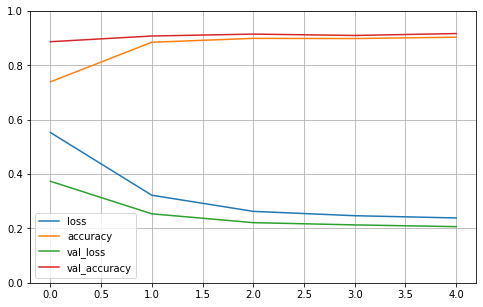

In [9]:
do_cross_validation(X,y)

## Test

In [13]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 2000 PC seqs
Test on 2000 NC seqs
accuracy: 89.63%
